#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 10
**CH10B Finding a good deal among hotels with multiple regression**

using the hotels-vienna dataset

version 1.0 2021-05-05

In [2]:
import os
from pathlib import Path
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

warnings.filterwarnings("ignore")


In [3]:
current_path = os.getcwd()
base_dir = current_path.split("da_case_studies")[0]
data_in = os.path.join(str(base_dir) , "da_data_repo/hotels-vienna/clean/")
data_out = os.path.join(str(base_dir), "da_case_studies/ch10-hotels-multiple-reg/")
func = os.path.join(str(base_dir) ,   "da_case_studies/ch00-tech-prep/")
sys.path.append(func)

In [4]:
from py_helper_functions import *

In [5]:
hotels = pd.read_csv(os.path.join(data_in, "hotels-vienna.csv"))

In [6]:
hotels = hotels.loc[
    lambda x: (x["accommodation_type"] == "Hotel")
    & (x["city_actual"] == "Vienna")
    & (x["stars"] >= 3)
    & (x["stars"] <= 4)
    & (x["price"] <= 600)
    & (x["stars"].notnull())
]

In [7]:
len(hotels)

207

In [8]:
hotels["lnprice"] = np.log(hotels["price"])
hotels["distance2"] = hotels["distance"]
hotels.loc[hotels["distance2"] < 0.05, "distance2"] = 0.05
hotels["lndistance"] = np.log(hotels["distance2"])
hotels["star35"] = hotels["stars"] == 3.5
hotels["star4"] = hotels["stars"] == 4

In [9]:
hotels[["distance", "price", "lnprice"]].describe()

,distance,price,lnprice
count,207.000000,207.000000,207.000000
mean,1.529952,109.975845,4.640219
std,1.161507,42.221381,0.336751
min,0.000000,50.000000,3.912023
25%,0.800000,82.000000,4.406719
50%,1.300000,100.000000,4.605170
75%,1.900000,129.500000,4.863673
max,6.600000,383.000000,5.948035


In [10]:
reg0 = smf.ols("lnprice ~ rating", data=hotels).fit()
reg1 = smf.ols("lnprice ~ distance", data=hotels).fit()
reg2 = smf.ols("lnprice ~ distance + rating", data=hotels).fit()

In [11]:
Stargazer([reg0,reg1,reg2])

In [12]:
y, X = dmatrices(
    "lnprice ~ lspline(distance,[1,4]) + lspline(rating, 3.5) + star35 + star4", hotels
)

reg3 = sm.OLS(y, X).fit()

In [13]:
print(reg3.summary())

                            OLS Regression Results                            
Dep. Variable:                lnprice   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     34.76
Date:                Sun, 15 Sep 2024   Prob (F-statistic):           2.19e-31
Time:                        13:53:28   Log-Likelihood:                 14.744
No. Observations:                 207   AIC:                            -13.49
Df Residuals:                     199   BIC:                             13.17
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [14]:
hotels["lnprice_hat"] = reg3.predict(X)

hotels["lnprice_resid"] = hotels["lnprice"] - hotels["lnprice_hat"]

hotels["bestdeals"] = hotels.index.isin(
    hotels["lnprice_resid"].sort_values(ascending=False).tail().index.values
)

In [15]:
reg4 = smf.ols(
    "lnprice ~ lspline(distance,[1,4])",
    data=hotels,
).fit()

In [16]:
print(reg4.summary())

                            OLS Regression Results                            
Dep. Variable:                lnprice   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     39.97
Date:                Sun, 15 Sep 2024   Prob (F-statistic):           2.43e-20
Time:                        13:53:28   Log-Likelihood:                -19.879
No. Observations:                 207   AIC:                             47.76
Df Residuals:                     203   BIC:                             61.09
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [17]:
#refit reg3 for Stargazer

reg3 = smf.ols(
    "lnprice ~ lspline(distance,[1,4]) + lspline(rating, 3.5) + star35 + star4",
    data=hotels,
).fit()

In [18]:
Stargazer([reg1, reg2, reg3, reg4])

### Figure 10.3 ˆy−y plot for log hotel price

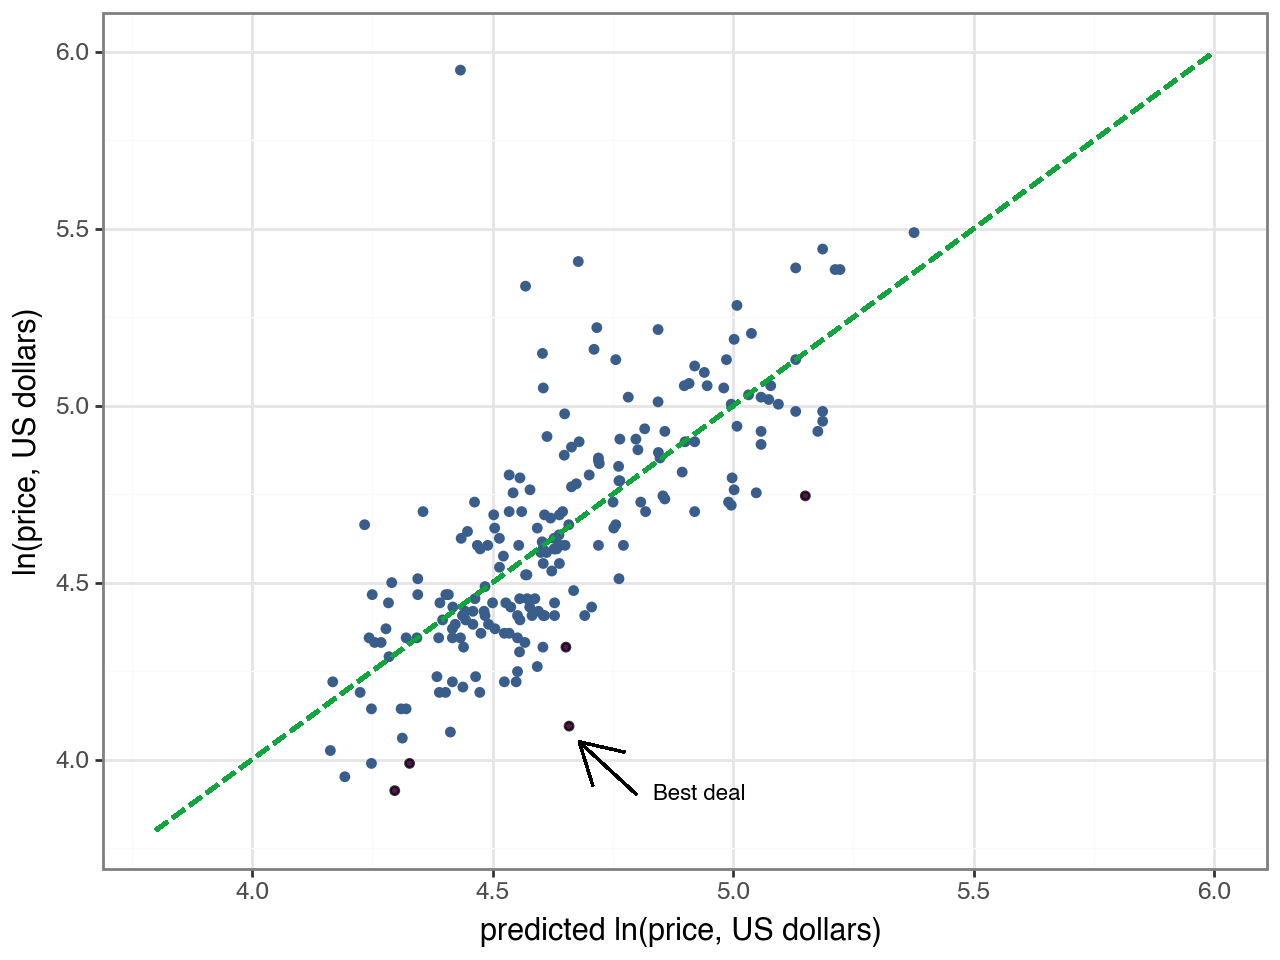

In [20]:
y_yhat_hotels = (
    ggplot(data=hotels)
    + geom_point(
        aes(x="lnprice_hat", y="lnprice", color="bestdeals", fill="bestdeals"),
        size=1.2,
        alpha=0.8,
    )
    + geom_segment(
        aes(x=3.8, y=3.8, xend=6, yend=6), size=0.8, color=color[1], linetype="dashed"
    )
    + labs(x="predicted ln(price, US dollars) ", y="ln(price, US dollars)")
    + scale_colour_manual(values=[color[0], "black"], guide=None)
    + scale_fill_manual(values=(color[0], color[2]), guide=None)
    + geom_segment(aes(x=4.8, y=3.9, xend=4.68, yend=4.05), arrow=arrow())
    + annotate("text", x=4.93, y=3.9, label="Best deal", size=8)
    + theme_bw()
)
y_yhat_hotels

### Residual plot - not in the book

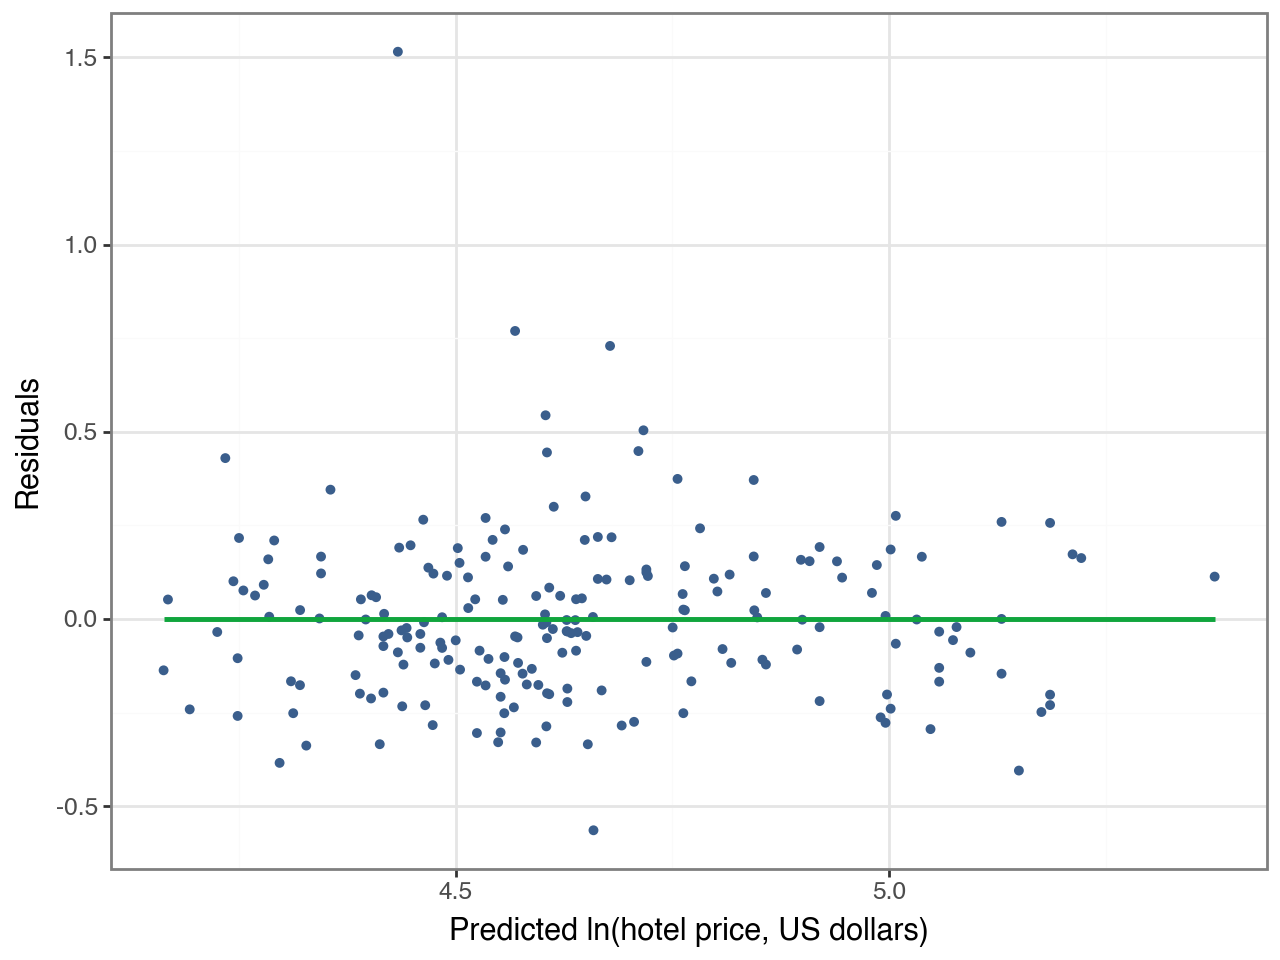

In [22]:
y_hat_resid_hotels = (
    ggplot(data=hotels)
    + geom_point(
        aes(x="lnprice_hat", y="lnprice_resid"),
        color=color[0],
        size=1,
        fill=color[0],
        alpha=0.6,
    )
    + geom_smooth(
        aes(x="lnprice_hat", y="lnprice_resid"),
        method="lm",
        color=color[1],
        size=1,
        se=False,
    )
    + labs(x="Predicted ln(hotel price, US dollars)", y="Residuals")
    + scale_colour_manual(name="", values=[color[1], "black"])
    + theme_bw()
)
y_hat_resid_hotels